# COVID-19 CT Scan Lesion Segmentation
<h2>MSCSF21M507</h2>

In [1]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)
# !conda activate tf_gpu
# !conda info


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10707169400835191254
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4853137408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 110930217297559586
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SIZE = 512
num_images = 2729

In [4]:
image_directory = '../DL/Untitled Folder/FullData/frames'
mask_directory = '..\DL/Untitled Folder/FullData/masks'

In [5]:
image_names = glob.glob("../DL/Untitled Folder/FullData/frames/*.png")
# print(image_names)
image_names.sort()
print(image_names)

['../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_100.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_101.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_102.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_103.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_104.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_105.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_106.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_107.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_108.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_109.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_110.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_111.png', '../DL/Untitled Folder/FullData/frames\\Jun_coronacases_case10_112.png', '../DL/Untitled Folder/FullData/frames\\Jun_corona

In [6]:
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]

In [7]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [8]:
mask_names = glob.glob("../DL/Untitled Folder/FullData//masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [9]:
# for i in range(2729):
#     if ((image_names[i][38:] != mask_names[i][38:])):
#         print((image_names[i][38:],mask_names[i][38:]))
#         i = i+1
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (2729, 512, 512, 1)
Mask data shape is:  (2729, 512, 512, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0  12  17  21 255]


In [10]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset //255.  #PIxel values will be 0 or 1

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


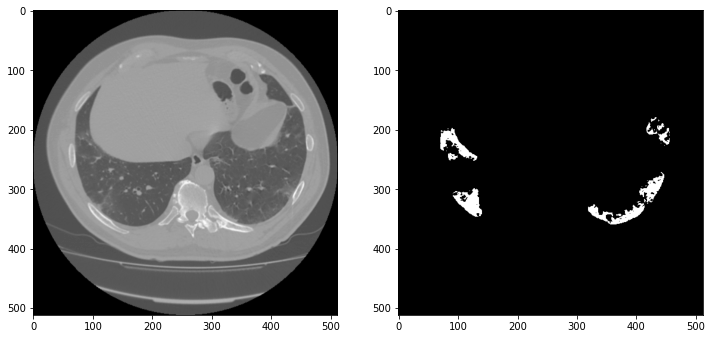

In [16]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()


In [12]:
# Building Unet by dividing encoder and decoder into blocks

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s0, p0 = encoder_block(inputs, 32)
    s1, p1 = encoder_block(p0, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    d5 = decoder_block(d4, s0, 32)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d5)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [17]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)
image_dataset = None
mask_dataset = None
images = None
masks = None

(512, 512, 1)


In [14]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [15]:
# from tensorflow.keras.utils import Sequence
# import numpy as np   

# class DataGenerator(Sequence):
#     def __init__(self, x_set, y_set, batch_size):
#         self.x, self.y = x_set, y_set
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.x) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return batch_x, batch_y

# train_g = DataGenerator(X_train, y_train, 16)
# test_g = DataGenerator(X_test, y_test, 16)
# print(train_g)

In [16]:
history = model.fit(X_train, y_train, 
                    batch_size = 1, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/25
1383/1383 [==============================] - 2184s 2s/step - loss: 0.0481 - accuracy: 0.9879 - val_loss: 0.9644 - val_accuracy: 0.6752
Epoch 2/25
1383/1383 [==============================] - 432s 312ms/step - loss: 0.0217 - accuracy: 0.9920 - val_loss: 0.1961 - val_accuracy: 0.9301
Epoch 3/25
1383/1383 [==============================] - 432s 313ms/step - loss: 0.0194 - accuracy: 0.9928 - val_loss: 0.2715 - val_accuracy: 0.8852
Epoch 4/25
1383/1383 [==============================] - 427s 309ms/step - loss: 0.0169 - accuracy: 0.9935 - val_loss: 0.1985 - val_accuracy: 0.9401
Epoch 5/25
1383/1383 [==============================] - 428s 309ms/step - loss: 0.0158 - accuracy: 0.9939 - val_loss: 0.2271 - val_accuracy: 0.9294
Epoch 6/25
1383/1383 [==============================] - 437s 316ms/step - loss: 0.0141 - accuracy: 0.9944 - val_loss: 0.2107 - val_accuracy: 0.9393
Epoch 7/25
1383/1383 [==============================] - 443s 321ms/step - loss: 0.0134 - accuracy: 0.9946 - val_lo

In [17]:
model.save('../saved_models/Unet_25epochs.hdf5')

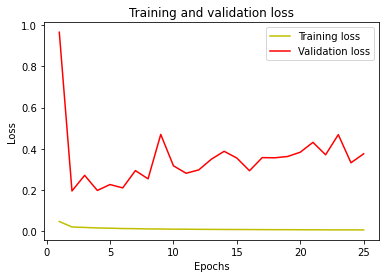

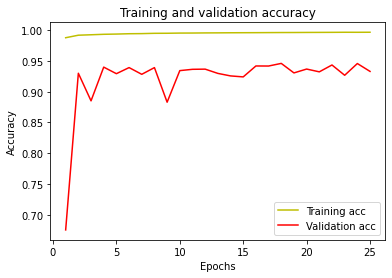

In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
#Load previously saved model
from tensorflow.keras.models import load_model
model = load_model("../saved_models/Unet_25epochs(miniset).hdf5", compile=False)

In [19]:
#IOU
y_pred=model.predict(X_test,batch_size=1)
y_pred_thresholded = y_pred > 0.5


In [37]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded[:], y_test[:])
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.60990273


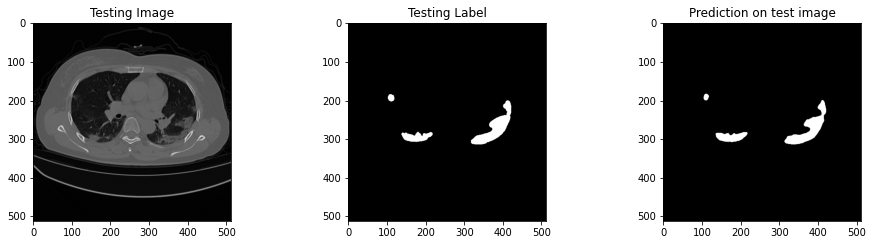

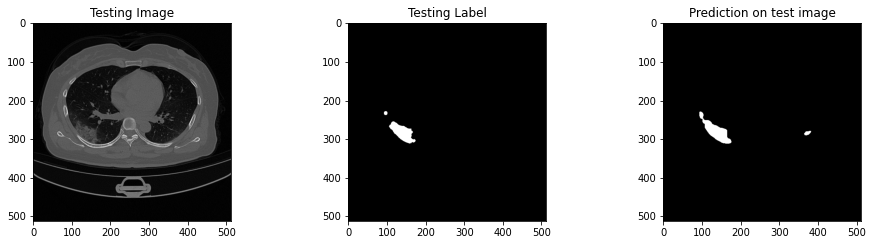

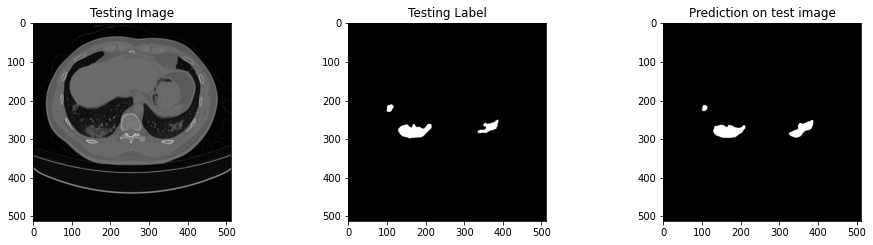

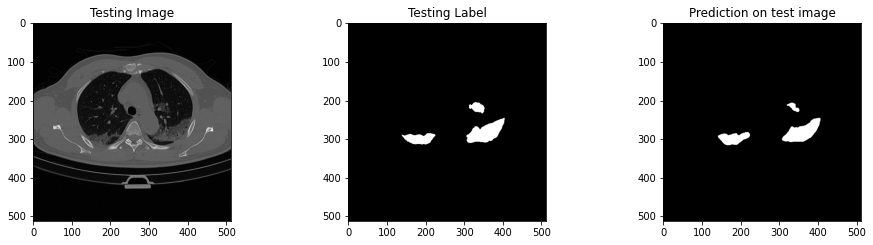

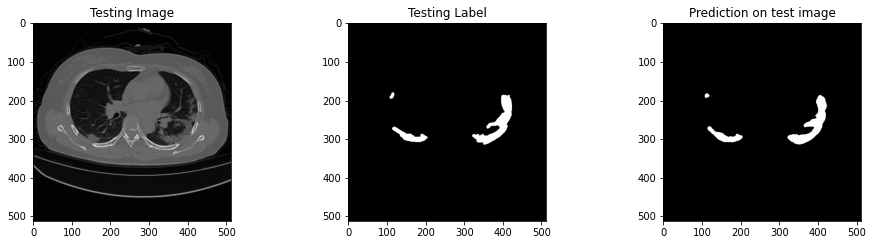

In [43]:
for i in range(5):    
    threshold = 0.5
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
#     print(test_img_input.shape)
    prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
#     print(prediction.shape)

    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')

    plt.show()

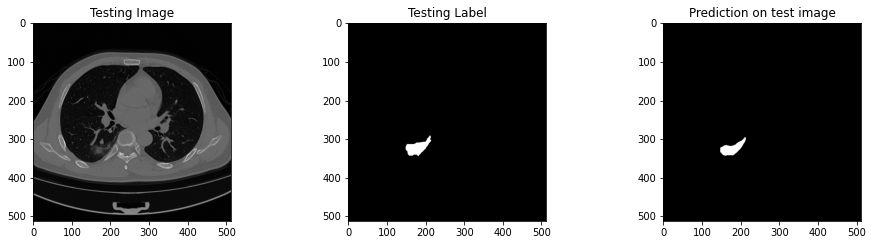

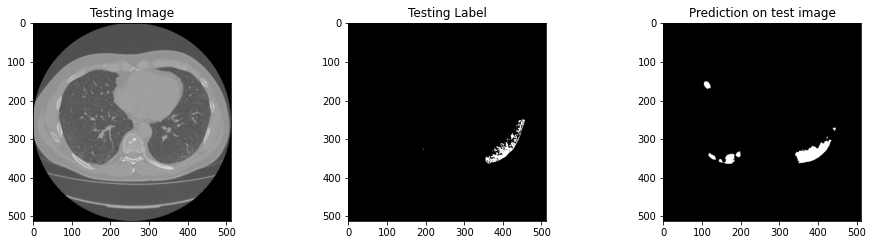

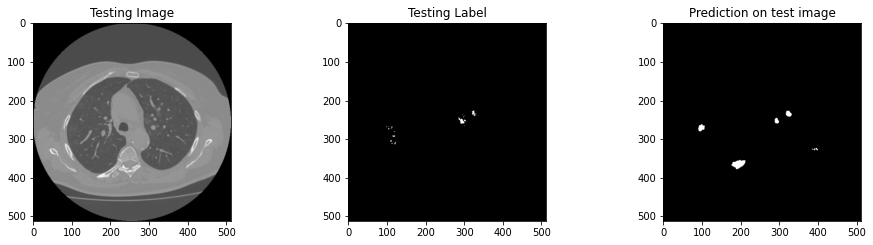

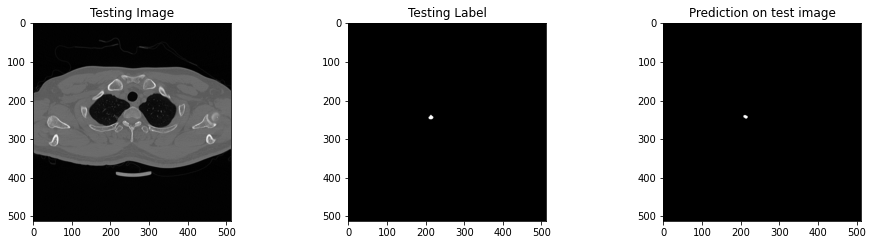

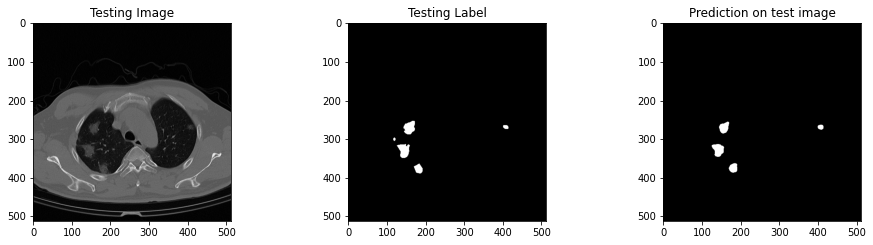